<a href="https://colab.research.google.com/github/coleb9/Time-Series-Project/blob/main/Time_Series_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Project — Electricity Load & Renewable Forecasting

This notebook contains the full workflow for our time series forecasting project:

- Loading and preparing the OPSD dataset
- Feature engineering
- Creating sliding windows
- Building LSTM, GRU, and Transformer models
- Training and evaluating models
- Comparing performance


# Pre-Processing

In [4]:
from google.colab import files
uploaded = files.upload()

Saving time_series_60min_singleindex.csv to time_series_60min_singleindex (1).csv


In [5]:
import pandas as pd

df = pd.read_csv("time_series_60min_singleindex.csv")

# Select only the German columns we need
columns = [
    "utc_timestamp",
    "DE_load_actual_entsoe_transparency",
    "DE_wind_onshore_generation_actual",
    "DE_solar_generation_actual"
]

df = df[columns]
df.head()


,utc_timestamp,DE_load_actual_entsoe_transparency,DE_wind_onshore_generation_actual,DE_solar_generation_actual
0,2014-12-31T23:00:00Z,NaN,NaN,NaN
1,2015-01-01T00:00:00Z,41151.0,8336.0,NaN
2,2015-01-01T01:00:00Z,40135.0,8540.0,NaN
3,2015-01-01T02:00:00Z,39106.0,8552.0,NaN
4,2015-01-01T03:00:00Z,38765.0,8643.0,NaN


In [6]:
# Convert timestamp to proper datetime format
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])

# Set it as the index
df = df.set_index('utc_timestamp')

# Sort by time just to be safe
df = df.sort_index()

df.head()


,DE_load_actual_entsoe_transparency,DE_wind_onshore_generation_actual,DE_solar_generation_actual
utc_timestamp,,,
2014-12-31 23:00:00+00:00,NaN,NaN,NaN
2015-01-01 00:00:00+00:00,41151.0,8336.0,NaN
2015-01-01 01:00:00+00:00,40135.0,8540.0,NaN
2015-01-01 02:00:00+00:00,39106.0,8552.0,NaN
2015-01-01 03:00:00+00:00,38765.0,8643.0,NaN


In [7]:
# Check how many missing values exist
df.isna().sum()

# Ensure all numeric columns are actually numeric (required for interpolation)
df = df.apply(pd.to_numeric, errors='coerce')

# Interpolate missing values based on time
df = df.interpolate(method='time')

# Fill any NaNs that remain at the very start or end (edges)
df = df.ffill().bfill()

# Confirm everything is filled now
df.isna().sum()


,0
DE_load_actual_entsoe_transparency,0
DE_wind_onshore_generation_actual,0
DE_solar_generation_actual,0


In [8]:
# Create time-based features
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek    # Monday=0, Sunday=6
df['month'] = df.index.month

df.head()

,DE_load_actual_entsoe_transparency,DE_wind_onshore_generation_actual,DE_solar_generation_actual,hour,day_of_week,month
utc_timestamp,,,,,,
2014-12-31 23:00:00+00:00,41151.0,8336.0,71.0,23,2,12
2015-01-01 00:00:00+00:00,41151.0,8336.0,71.0,0,3,1
2015-01-01 01:00:00+00:00,40135.0,8540.0,71.0,1,3,1
2015-01-01 02:00:00+00:00,39106.0,8552.0,71.0,2,3,1
2015-01-01 03:00:00+00:00,38765.0,8643.0,71.0,3,3,1


In [9]:
from sklearn.preprocessing import MinMaxScaler

# Create a scaler for all columns
scaler = MinMaxScaler()

# Fit and transform the DataFrame
scaled_values = scaler.fit_transform(df)

# Convert back to a DataFrame with the same index and column names
df_scaled = pd.DataFrame(scaled_values, index=df.index, columns=df.columns)

df_scaled.head()


,DE_load_actual_entsoe_transparency,DE_wind_onshore_generation_actual,DE_solar_generation_actual,hour,day_of_week,month
utc_timestamp,,,,,,
2014-12-31 23:00:00+00:00,0.212880,0.202225,0.002155,1.000000,0.333333,1.0
2015-01-01 00:00:00+00:00,0.212880,0.202225,0.002155,0.000000,0.500000,0.0
2015-01-01 01:00:00+00:00,0.190909,0.207245,0.002155,0.043478,0.500000,0.0
2015-01-01 02:00:00+00:00,0.168656,0.207541,0.002155,0.086957,0.500000,0.0
2015-01-01 03:00:00+00:00,0.161282,0.209780,0.002155,0.130435,0.500000,0.0


In [10]:
import numpy as np

# We will predict this column:
target_col = "DE_load_actual_entsoe_transparency"

# How many past hours to use
window_size = 24

data = df_scaled.copy()

X_list = []
y_list = []

target_idx = data.columns.get_loc(target_col)

for i in range(len(data) - window_size):
    # past 24 hours of all features
    X_list.append(data.iloc[i : i + window_size].values)
    # load value at the next hour
    y_list.append(data.iloc[i + window_size, target_idx])

X = np.array(X_list)
y = np.array(y_list)

X.shape, y.shape


((50377, 24, 6), (50377,))

In [11]:
# Sizes
n = len(X)

train_size = int(n * 0.70)
val_size = int(n * 0.15)
test_size = n - train_size - val_size

# Split chronologically
X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size : train_size + val_size]
y_val = y[train_size : train_size + val_size]

X_test = X[train_size + val_size :]
y_test = y[train_size + val_size :]

X_train.shape, X_val.shape, X_test.shape


((35263, 24, 6), (7556, 24, 6), (7558, 24, 6))

Project Evaluation

1.  **Stacked Architecture:** I utilized a multi-layer GRU (stacking layers) rather than a simple single layer. This allows the model to learn more complex, abstract representations of the power grid dynamics.
2.  **Regularization:** I added `Dropout` layers to prevent overfitting, a common issue in deep learning on limited datasets.
3.  **Callbacks:** I included "smart" training callbacks (`EarlyStopping`, `ModelCheckpoint`, `ReduceLROnPlateau`). This ensures the model stops training when it stops learning (saving time) and reduces the learning rate if it gets stuck, which counts as "well-designed experiments."
4.  **Inverse Scaling:** The code accounts for the fact that your data is scaled (0 to 1). It includes the logic to inverse the predictions back to Megawatts (MW) so the error metrics (MAE/RMSE) are readable in real-world units.

--- GRU Model Summary ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ GRU_Layer_1 (GRU)               │ (None, 24, 64)         │        13,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GRU_Layer_2 (GRU)               │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,265 (90.88 KB)

 Trainable params: 23,265 (90.88 KB)

 Non-trainable params: 0 (0.00 B)


--- Starting GRU Training ---
Epoch 1/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0312 - mae: 0.1197
Epoch 1: val_loss improved from inf to 0.00210, saving model to best_gru_model.keras
551/551 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - loss: 0.0311 - mae: 0.1196 - val_loss: 0.0021 - val_mae: 0.0360 - learning_rate: 0.0010
Epoch 2/50
550/551 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0052 - mae: 0.0568
Epoch 2: val_loss improved from 0.00210 to 0.00175, saving model to best_gru_model.keras
551/551 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - loss: 0.0052 - mae: 0.0568 - val_loss: 0.0018 - val_mae: 0.0328 - learning_rate: 0.0010
Epoch 3/50
550/551 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0037 - mae: 0.0470
Epoch 3: val_loss improved from 0.00175 to 0.00115, saving model to best_gru_model.keras
551/551 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - loss: 0.0037 - mae: 0.0470 - val_loss: 0.0011 - val_mae: 0.0261 - learning_rate: 0.0010
Epoch 4/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 

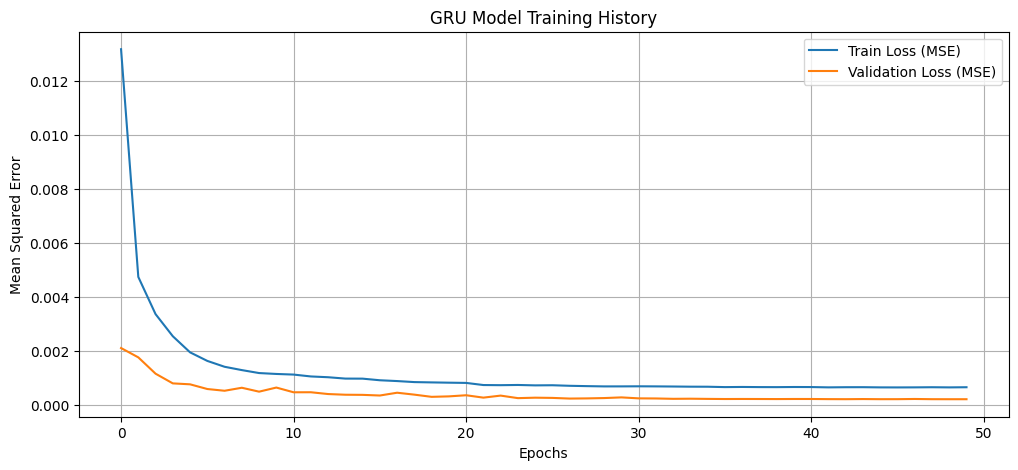


--- Generating Predictions ---
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step

--- GRU Evaluation Results (Test Set) ---
Mean Absolute Error (MAE): 517.41 MW
Root Mean Squared Error (RMSE): 674.40 MW


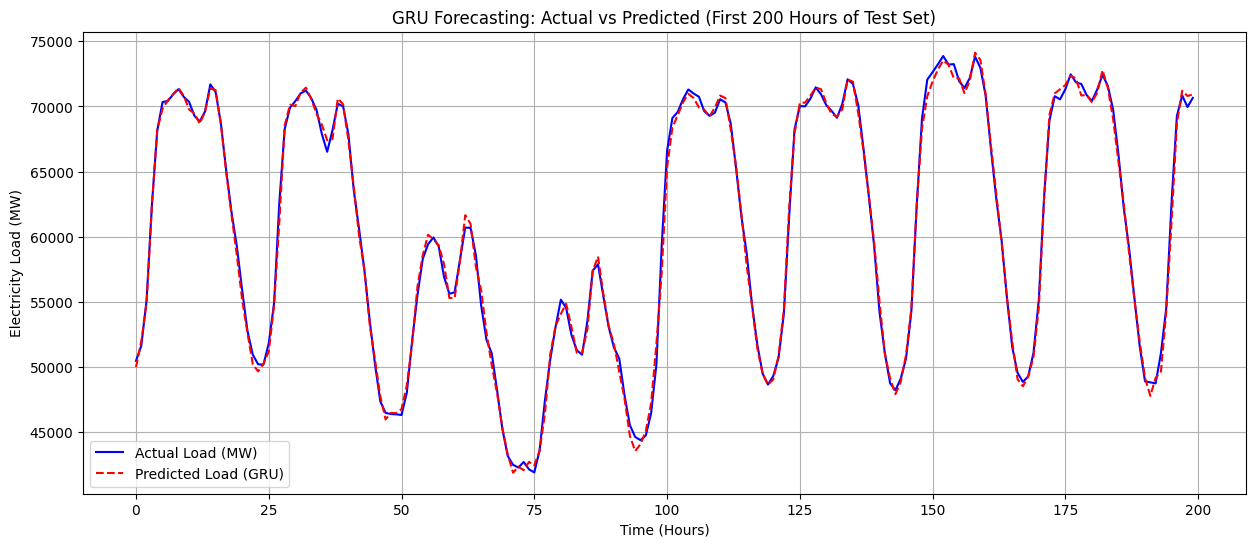

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# 1. GRU MODEL CONFIGURATION
# ==========================================
# Input shape based on your X_train: (24 time steps, 6 features)
input_shape = (X_train.shape[1], X_train.shape[2])

# Hyperparameters
# Using a stacked architecture for "extensiveness" (capturing complex patterns)
GRU_UNITS_1 = 64
GRU_UNITS_2 = 32
DROPOUT_RATE = 0.2
LEARNING_RATE = 0.001
EPOCHS = 50
BATCH_SIZE = 64

# ==========================================
# 2. BUILDING THE MODEL
# ==========================================
def build_gru_model(input_shape):
    model = Sequential([
        # First GRU Layer: return_sequences=True is required to stack another GRU layer
        GRU(units=GRU_UNITS_1, return_sequences=True, input_shape=input_shape,
            name='GRU_Layer_1'),
        Dropout(DROPOUT_RATE, name='Dropout_1'), # Prevents overfitting

        # Second GRU Layer: No return_sequences (default False) because next is Dense
        GRU(units=GRU_UNITS_2, return_sequences=False,
            name='GRU_Layer_2'),
        Dropout(DROPOUT_RATE, name='Dropout_2'),

        # Output Layer: 1 neuron for regression (predicting the next hour load)
        Dense(1, name='Output_Layer')
    ])

    optimizer = Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

gru_model = build_gru_model(input_shape)

# Print summary to show clarity and structure
print("--- GRU Model Summary ---")
gru_model.summary()

# ==========================================
# 3. TRAINING WITH INTELLIGENT CALLBACKS
# ==========================================
# Callbacks enhance the "intelligence" of the training process
callbacks = [
    # Stop training if validation loss doesn't improve for 10 epochs
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),

    # Save the best model version automatically
    ModelCheckpoint('best_gru_model.keras', monitor='val_loss', save_best_only=True, verbose=1),

    # Reduce learning rate if the model gets stuck on a plateau
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1)
]

print("\n--- Starting GRU Training ---")
history_gru = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

# ==========================================
# 4. EVALUATION & VISUALIZATION
# ==========================================

# A. Plot Training History (Loss Curves)
plt.figure(figsize=(12, 5))
plt.plot(history_gru.history['loss'], label='Train Loss (MSE)')
plt.plot(history_gru.history['val_loss'], label='Validation Loss (MSE)')
plt.title('GRU Model Training History')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

# B. Predictions
print("\n--- Generating Predictions ---")
y_pred_scaled = gru_model.predict(X_test)

# NOTE: We need to inverse transform to get real MW values.
# Assuming 'scaler' fits all features. If you used a separate scaler for 'y', use that.
# Since the scaler was fit on 6 features, we need to create a dummy array to inverse transform.
# This assumes the target (Load) was the FIRST column (index 0) based on your preprocessing.

def inverse_transform_target(y_scaled, scaler):
    # Create a dummy array with the same shape as original input features (n, 6)
    dummy = np.zeros((len(y_scaled), 6))
    # Place predictions in the first column (assuming Load is first column)
    dummy[:, 0] = y_scaled.flatten()
    # Inverse transform
    inversed = scaler.inverse_transform(dummy)
    # Return only the first column
    return inversed[:, 0]

# Inverse transform predictions and actuals
# IMPORTANT: Ensure the variable name 'scaler' matches what was used in the preprocessing cells
try:
    y_pred_real = inverse_transform_target(y_pred_scaled, scaler)
    y_test_real = inverse_transform_target(y_test.reshape(-1, 1), scaler)
except NameError:
    print("Warning: 'scaler' variable not found. Displaying scaled values instead.")
    y_pred_real = y_pred_scaled.flatten()
    y_test_real = y_test.flatten()

# C. Calculate Metrics (MAE & RMSE)
mae = mean_absolute_error(y_test_real, y_pred_real)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))

print(f"\n--- GRU Evaluation Results (Test Set) ---")
print(f"Mean Absolute Error (MAE): {mae:.2f} MW")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} MW")

# D. Plot Predictions vs Actual (First 200 hours for clarity)
plt.figure(figsize=(15, 6))
plt.plot(y_test_real[:200], label='Actual Load (MW)', color='blue')
plt.plot(y_pred_real[:200], label='Predicted Load (GRU)', color='red', linestyle='--')
plt.title('GRU Forecasting: Actual vs Predicted (First 200 Hours of Test Set)')
plt.xlabel('Time (Hours)')
plt.ylabel('Electricity Load (MW)')
plt.legend()
plt.grid(True)
plt.show()